### Import data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
import sys
import os

sys.path.append(os.path.abspath(".."))  
sys.path.append(os.path.abspath("./src"))  

from src.data_processing import extract_features
from src.model import  self_calculate_bartlett_sphericity, filter_variables_by_kmo
from src.visualization import plot_factor_loadings


# Load dataset file with labels and features (FCC)
data_path = "../data/"
audio_path = "../audios/"


#dataset ='Dataset_1/'
#dataset ='Dataset_2/'
dataset ='Automatic_Labeling_Kyoogu/'

file = 'Labeled_Data_With_FCCs.xlsx'
df = pd.read_excel(data_path+dataset+file)

df_filtered = df[df['Specie ID'] != 'noise']
df_filtered = df_filtered.dropna(subset=['Specie ID'])
print(df_filtered['Specie ID'].value_counts())  


Specie ID
Boana_platanera                349
Leptodactylus_fragilis         325
Leptodactylus_fuscus           305
Patagioenas_cayennensis        165
Dendropsophus_microcephalus    112
Dendroplex_picus                76
Troglodytes_aedon               29
Alouatta_sp                     21
Name: count, dtype: int64


## Extraction of Spectral Features and concatenation with previous features 

In [2]:

G_matrix_segments = df_filtered[['File', 'Specie ID', 'Start', 'End', 'FminVoc', 'FmaxVoc']]
#print(G_matrix_segments.head())


if dataset == 'Dataset_2/':
    prefix = audio_path + dataset    
else:
    prefix = audio_path + 'Dataset_1/'   


Y_spectral_features = []
for _, row in G_matrix_segments.iterrows():
    file_path = prefix + row['File']
    #print(f"Processing file: {file_path}")
    features = extract_features(
        path=file_path,
        start=row['Start'],
        end=row['End'],
        freq_range=(row['FminVoc'], row['FmaxVoc'])
    )
    Y_spectral_features.append(features)

# Convert the list of dictionaries into a DataFrame
Y_df_spectral_features = pd.DataFrame(Y_spectral_features)
Y_df_spectral_features = Y_df_spectral_features.reset_index(drop=True)
Y_df_spectral_features.index = G_matrix_segments.index

df_allFeatures = pd.concat([df_filtered, Y_df_spectral_features], axis=1)
df_allFeatures  

,File,Specie ID,Start,End,FminVoc,FmaxVoc,Fdom,FCC1,FCC2,FCC3,...,FCC19,FCC20,FCC21,FCC22,FCC23,SpectralCentroid,Bandwidth,SpectralFlatness,Length,DeltaFreq
0,SMA03126_20210611_200000.wav,Boana_platanera,1.2,3.199,1.2,2500,2529.980488,-2.929353,2.864602,-1.819670,...,-0.088081,0.805879,0.583809,-0.054626,0.516533,142.705564,208.074249,0.052909,1.999,2498.8
1,SMA03126_20210611_200000.wav,Boana_platanera,2.0,3.999,2.0,2500,2530.780488,-3.852549,2.218462,-2.664421,...,0.139753,0.489719,-0.282179,-0.593289,-0.227796,148.697025,215.702444,0.056735,1.999,2498.0
2,SMA03126_20210611_200000.wav,Boana_platanera,8.8,10.799,8.8,2500,2537.580488,-2.007076,3.238212,-1.505718,...,-0.019906,0.923981,0.524091,-0.043802,0.336594,170.685233,294.070649,0.064193,1.999,2491.2
3,SMA03126_20210611_200000.wav,Boana_platanera,9.6,11.599,9.6,2500,2538.380488,-1.842339,3.285941,-1.423196,...,-0.357885,0.675144,-0.244911,-0.295990,0.055367,160.675951,259.236291,0.057370,1.999,2490.4
4,SMA03126_20210611_200000.wav,Boana_platanera,12.8,14.799,12.8,2500,2518.165854,-2.599878,1.658349,-2.119815,...,0.038951,-0.581507,-1.090474,-1.311246,-0.667180,155.110997,263.300619,0.060152,1.999,2487.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,SMA03251_20210605_053000.wav,Troglodytes_aedon,54.0,55.999,54.0,7000,7031.560976,-0.029979,2.392827,-2.043617,...,0.316761,-6.490697,-2.456437,1.215712,0.305538,3526.336320,2669.097747,0.165309,1.999,6946.0
1378,SMA03251_20210608_073000.wav,Troglodytes_aedon,10.8,12.799,10.8,7000,7035.190244,1.099034,0.696196,-3.326215,...,0.340347,3.072540,1.381415,-0.477690,-1.625452,3144.172166,2846.429962,0.159697,1.999,6989.2
1379,SMA03251_20210608_073000.wav,Troglodytes_aedon,32.8,34.799,32.8,7000,7033.775610,0.677080,0.964114,-2.265485,...,0.871002,-6.028390,-3.266161,0.114272,1.289721,3801.589040,2041.883464,0.135943,1.999,6967.2
1380,SMA03251_20210608_073000.wav,Troglodytes_aedon,43.6,45.599,43.6,7000,7021.160976,-1.202607,3.951664,-0.532044,...,-0.161219,-2.884795,-1.148504,0.839394,1.333195,3757.645848,2579.497331,0.123812,1.999,6956.4


### Divide features and labels, Scale Features

In [3]:
columns_to_remove = ['File','Specie ID','Specie', 'Taxon', 'sonotype', 'Peak Freq']  
df_only_features = df_allFeatures.drop(columns_to_remove, axis=1, errors='ignore') #Dataframe without labels, only features

# Standardize the features
scaler = StandardScaler()
only_features_scaled = scaler.fit_transform(df_only_features)

### Check Multinormality & Correlation Matrix with spearman

HZResults(hz=5528, pval=0.0, normal=False)


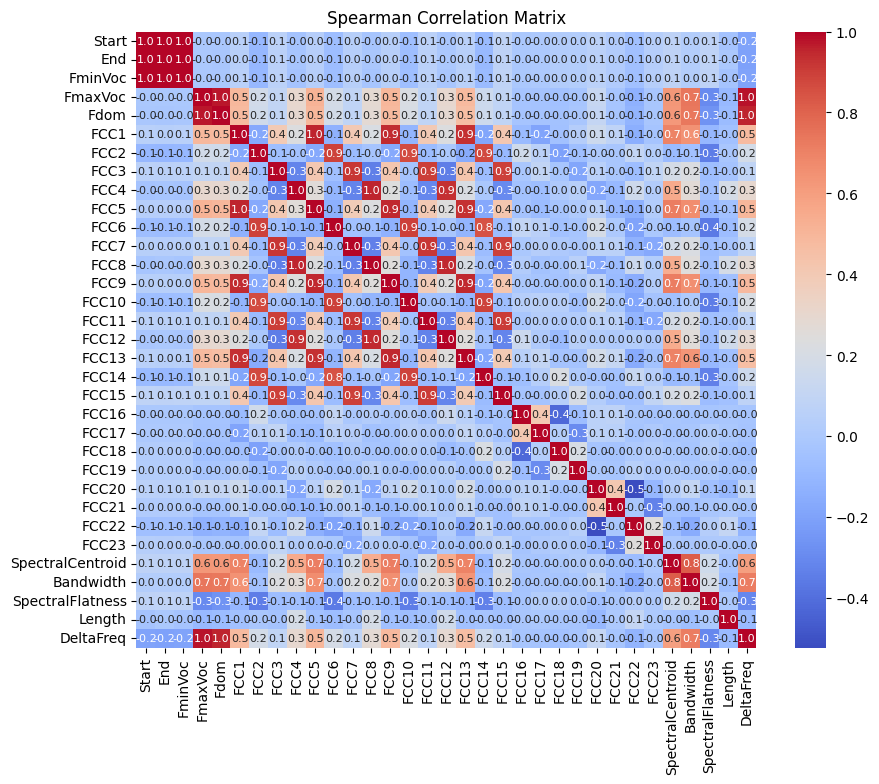

In [4]:
#Normality Test
normality_test = pg.multivariate_normality(only_features_scaled, alpha=0.05)
print(normality_test)

# Convert back to a DataFrame and assign column names
df_only_features_scaled = pd.DataFrame(only_features_scaled, columns=df_only_features.columns)
correlation_matrix = df_only_features_scaled.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 8})

plt.title('Spearman Correlation Matrix')
plt.show()

## Remove variables with high correlation


In [5]:
# Define the threshold for high correlation
threshold = 0.85

# Create a mask for the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Find the variables with high correlation
high_corr_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_vars.add(colname)

#high_corr_vars.add('FCC13')
print("Variables with high correlation:", high_corr_vars)

df_only_features_scaled = df_only_features_scaled.drop(columns=high_corr_vars, errors='ignore')



Variables with high correlation: {'DeltaFreq', 'Fdom', 'FCC6', 'End', 'FCC5', 'FCC11', 'FminVoc', 'FCC7', 'FCC9', 'FCC10', 'FCC15', 'FCC13', 'FCC14', 'FCC8', 'FCC12'}


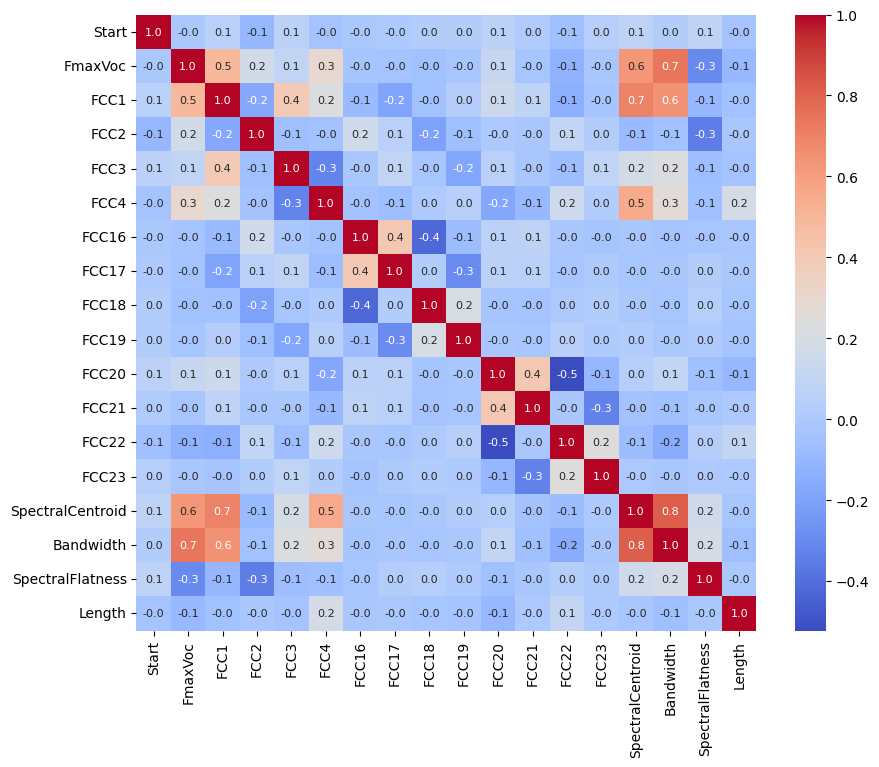

In [6]:
# Display the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))  # Set the size of the figure

# Calculate the correlation matrix using Spearman's method
correlation_matrix_reduced = df_only_features_scaled.corr(method='spearman')

# Generate the heatmap
sns.heatmap(correlation_matrix_reduced, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 8})

# Show the plot
plt.show()

### Bartlett Test

In [7]:
chi_square_value, p_value = self_calculate_bartlett_sphericity(df_only_features_scaled)
print(f"Results of the Bartlett Test are: Chi-square: {chi_square_value}, p-value: {p_value}")

Results of the Bartlett Test are: Chi-square: 9450.28396749934, p-value: 0.0


### KMO Test

KMO: 0.47744786160294833
Variables with value less than 0.4 are removed.
Detecting variables with low KMO...


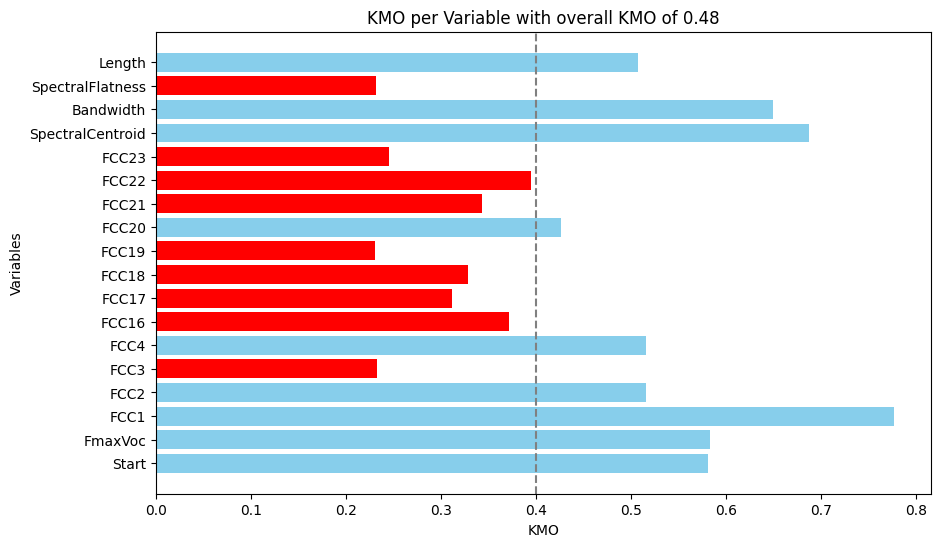

Calculating the new KMO...
The new KMO value after removing variables is: 0.7434638847265224


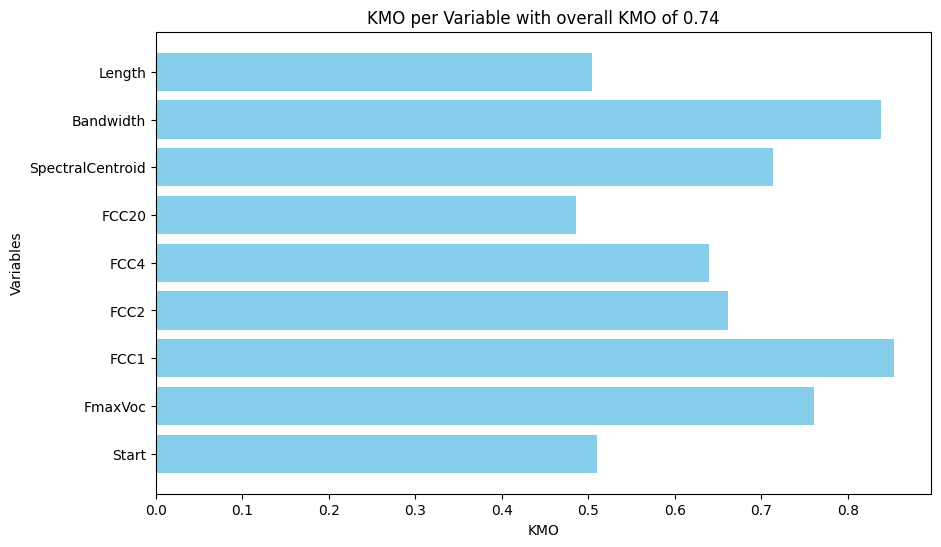

The final KMO value is: 0.7434638847265224
The removed variables are: 
            Variable
0              FCC3
1             FCC16
2             FCC17
3             FCC18
4             FCC19
5             FCC21
6             FCC22
7             FCC23
8  SpectralFlatness


In [8]:
df_filtered_afterKMO, variables_to_remove = filter_variables_by_kmo(df_only_features_scaled, limit = 0.4)

## Factor Analysis with Varimax Rotation

In [9]:
correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
# Factor Analysis with varimax rotation 
fa1 = FactorAnalyzer(n_factors=3, rotation='varimax', method="minres", is_corr_matrix=True)

# Fit the FactorAnalyzer model on the correlation matrix after KMO filtering
fa1.fit(correlation_matrix_afterKMO)

# Obtain loadings
loadings = fa1.loadings_

# Create a DataFrame with the factor loadings
loadings_df = pd.DataFrame(loadings, columns=[f'Factor{i+1}' for i in range(loadings.shape[1])], index=df_filtered_afterKMO.columns)

print("Factor loadings:")
print(loadings_df)


Factor loadings:
                   Factor1   Factor2   Factor3
Start             0.031422 -0.066704 -0.164639
FmaxVoc           0.819819 -0.142924  0.335319
FCC1              0.703900 -0.107534 -0.319133
FCC2             -0.009686 -0.060761  0.507509
FCC4              0.463786  0.778348  0.036846
FCC20             0.093714 -0.301230 -0.055923
SpectralCentroid  0.916329  0.159302 -0.200514
Bandwidth         0.886542 -0.150647 -0.063066
Length           -0.049521  0.271283 -0.005336


### Create Latent Variables

In [10]:
# Assign each variable to the factor with the highest loading
assignment = {}
for variable in loadings_df.index:
    max_loading_factor = loadings_df.loc[variable].abs().idxmax()
    max_loading_value = loadings_df.loc[variable, max_loading_factor]
    if round(abs(max_loading_value), 1) >= 0.35:
        assignment[variable] = (max_loading_factor, round(max_loading_value, 1))

# Create the latent variables (factors)
latent_variables = {f'Factor{i+1}': np.zeros(len(df_filtered_afterKMO)) for i in range(loadings.shape[1])}

for variable, (factor, weight) in assignment.items():
    latent_variables[factor] += weight * df_only_features[variable]

# Convert to DataFrame
df_latent = pd.DataFrame(latent_variables)

print("Latent Variables (factors):")
print(df_latent.head())


Latent Variables (factors):
       Factor1   Factor2   Factor3
0  2313.651285 -0.810538  1.432301
1  2325.262738 -1.609512  1.109231
2  2416.875341 -0.602763  1.619106
3  2376.631380  0.325938  1.642970
4  2374.750540 -1.097416  0.829175


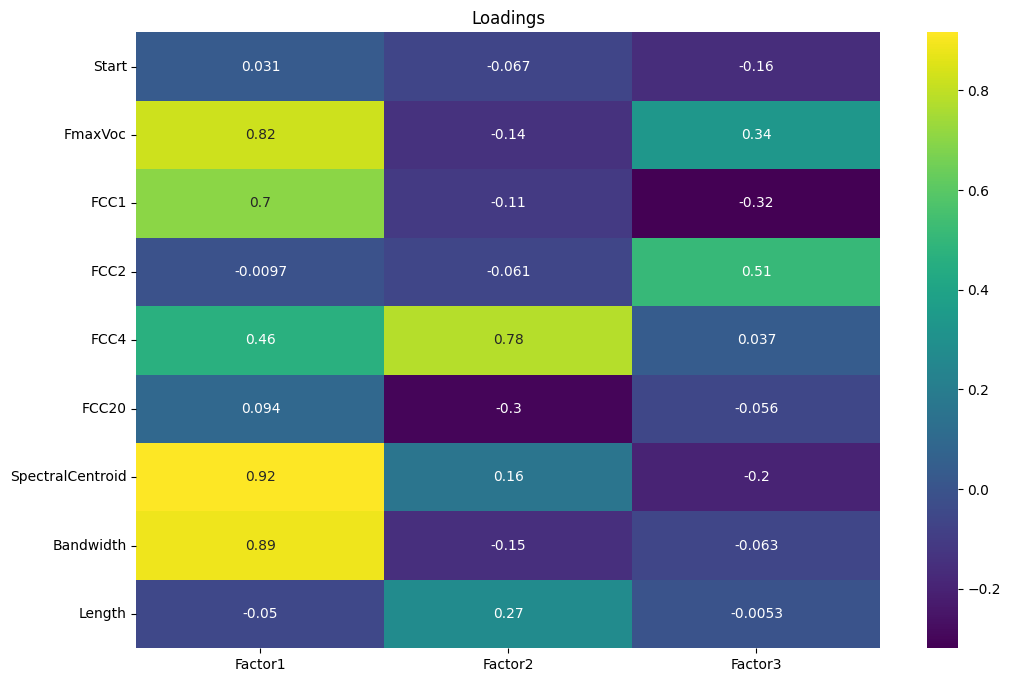

In [11]:
# Ploting the loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, annot=True, cmap='viridis')
plt.title('Loadings')
plt.show()

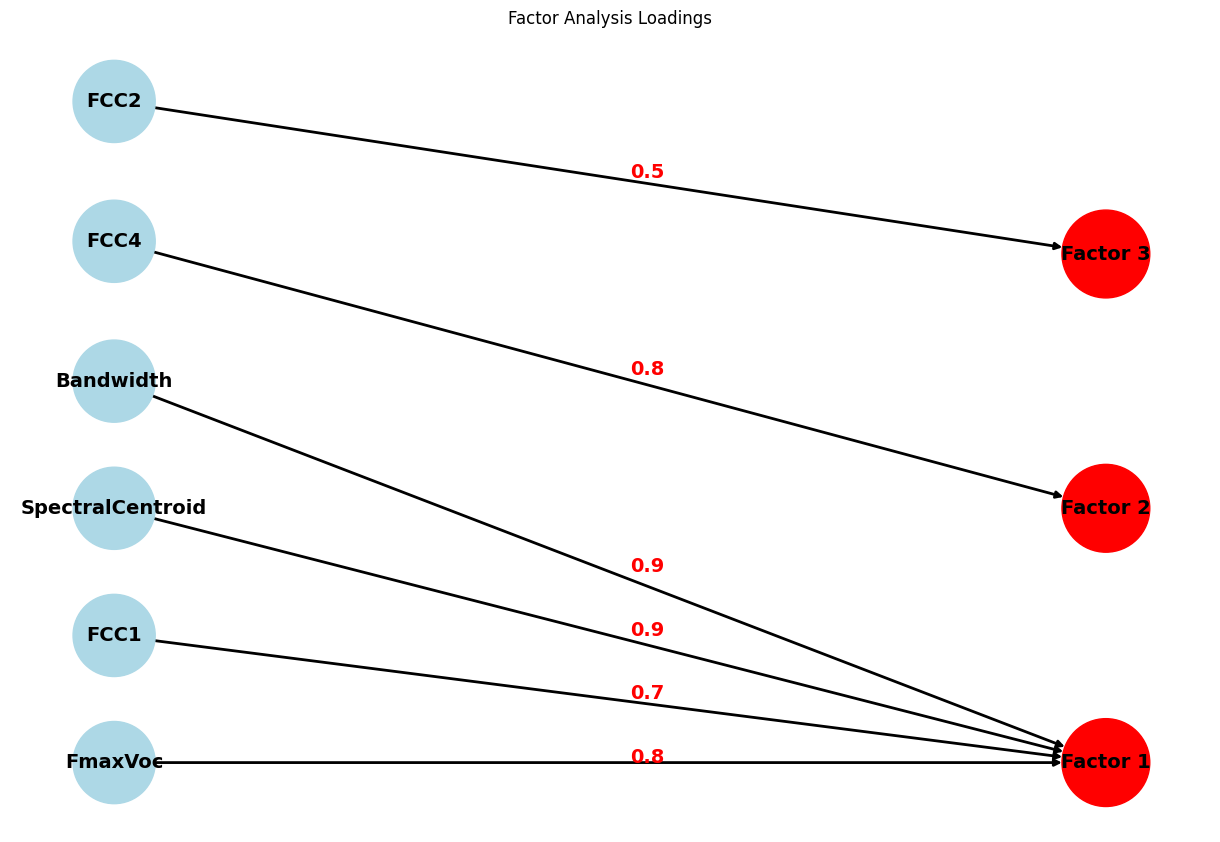

In [12]:
plot_factor_loadings(loadings_df)

### Create new dataset only with the latent variables and removed variables from KMO.

In [13]:
# Filter variables from variables_to_remove that do not start with "FCC"
variables_to_add = variables_to_remove[~variables_to_remove['Variable'].str.startswith('FCC')]

# Select the corresponding columns in df_only_features
Removed_Variables = df_only_features[variables_to_add['Variable']]

# Concatenate the filtered columns to df_reduced
df_reduced2 = pd.concat([df_latent, Removed_Variables], axis=1)
df_reduced2['Specie_ID'] = df_filtered['Specie ID']

# Verify the result
print("Combined DataFrame:")
print(df_reduced2.head())

outputfile = 'reduced_dataframe_FA2.xlsx'
#df_reduced2.to_excel(data_path+dataset+outputfile,index=True)


Combined DataFrame:
       Factor1   Factor2   Factor3  SpectralFlatness        Specie_ID
0  2313.651285 -0.810538  1.432301          0.052909  Boana_platanera
1  2325.262738 -1.609512  1.109231          0.056735  Boana_platanera
2  2416.875341 -0.602763  1.619106          0.064193  Boana_platanera
3  2376.631380  0.325938  1.642970          0.057370  Boana_platanera
4  2374.750540 -1.097416  0.829175          0.060152  Boana_platanera
